# How to Build a Recommeder System from Scratch

## By Jill Cates

# Agenda

1. What is a recommender system? 
1. Why do we need recommender systems?
1. How does it work?
1. Collaborative Filtering
1. Content-based Filtering 
1. Tutorial using MovieLens dataset

# What is a Recommender System?

- an application of machine learning
- predicts a user's preference towards a given item
- aims to drive user engagement

<h1 style="text-align:center">Examples of Recommenders</h1>

<img src="images/amazon-example.png" style="display:block;margin-left:auto;margin-right:auto;">

<h1 style="text-align:center">Examples of Recommenders</h1>

<img src="images/netflix-example.png" style="display:block;margin-left:auto;margin-right:auto;">

<h1 style="text-align:center">Examples of Recommenders</h1>

<img src="images/medium-example.png" style="display:block;margin-left:auto;margin-right:auto;">

<h1 style="text-align:center">Why Do We Need Recommender Systems?</h1>

<h3 style="text-align:center"> Before e-Commerce...</h3>

<p style="text-align:center"> Things were sold exclusively in brick-and-mortar stores </p>

<img src="images/bookstore.png" style="display:block;margin-left:auto;margin-right:auto;"/>

<p style="text-align:center"> limited inventory </p>
<p style="text-align:center"> mainstream products </p>


<h1 style="text-align:center">Why Do We Need Recommender Systems?</h1>

<h3 style="text-align:center"> e-Commerce...</h3>

<p style="text-align:center"> Introduction of the online marketplace </p>

<img src="images/amazon-ecommerce.png" style="display:block;margin-left:auto;margin-right:auto;width:50%;"/>

<p style="text-align:center"> unlimited inventory </p>
<p style="text-align:center"> niche products </p>


<h1 style="text-align:center">Why Do We Need Recommender Systems?</h1>

<p style="text-align:center;">"With the evolution of online retail, however, has come the revelation that being able to recategorize and rearrange products on the fly unlocks their real value." - Chris Anderson</p>

<img src="images/long-tail-book.png" style="display:block;margin-left:auto;margin-right:auto;width:50%;" width="35%"/>

# Tutorial

- Build an item-item recommender using the [MovieLens](https://movielens.org/) dataset 

# Step 1: Import Dependencies

We will be representing our data as a **Pandas DataFrame**.

- a two-dimensional data structure
- columns represent features, rows represent items
- analogous to an Excel spreadsheet or SQL table
- documentation can be found here

In [4]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load the Data

- Load the dataset from MovieLens 
- Consists of two files:
    - ratings.csv
    - movies.csv

In [5]:
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Step 3: Exploratory Data Analysis

`Ratings` contains users' ratings for a given movie. Let's see how many ratings, unique movies, and unique users are in our dataset.

In [7]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


How many ratings did each user make? Let's pandas' `groupby()` and `count()` to:
1. group the data by userId's
2. count the number of ratings for each userId.

In [8]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [9]:
print(f"Mean number of ratings for a given user: {user_freq['n_ratings'].mean():.2f}.")

Mean number of ratings for a given user: 165.30.


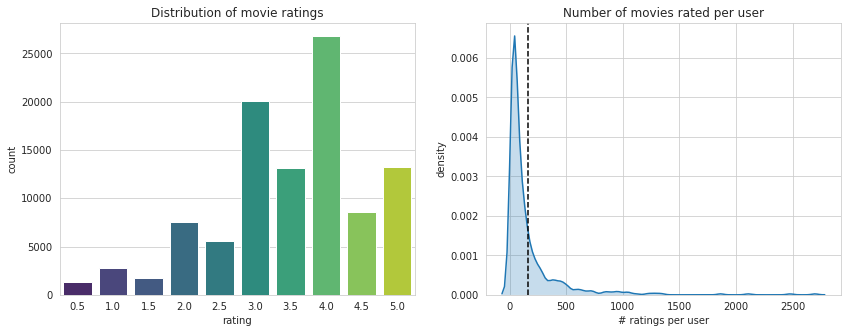

In [11]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
# plot 1
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

# plot 2
plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

In [55]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()
mean_rating.head()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


In [13]:
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [14]:
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


# Bayesian Average

In [25]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [57]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [28]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


In [29]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


# Step 4: Transforming the Data

* Collaborative filtering
* Need to wrangle data into user-item matrix

<img src="images/utility-matrix.png" width=70%/>

In [37]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe with columns 
        'userId', 'movieId', 'rating'.
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [31]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

### Calculating Sparsity of the Matrix

$S=\frac{\text{# non-zero elements}}{\text{total # elements}}$

In [32]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


### How to save your sparse matrix

You can use scipy's save_npz method. 

In [35]:
from scipy.sparse import save_npz

save_npz('user_item_matrix.npz', X)

# Step 5: Finding similar movies using k-Nearest Neighbours

In [36]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar movie ID's
    """
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [46]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}...")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995)...
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


In [48]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean")

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}...")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995)...
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)
Honey, I Shrunk the Kids (1989)
